# To run the notebook

Use Google Colab (should try to use GPU since training is really slow without it). Before running any code, upload *noisy-images.zip*, *train.csv* and *test.csv* to the filesystem first. Then run all the cells. 

After the last cell runs, two files called *image_train_pred.csv* and *image_test_pred.csv* should be saved to the filesystem. Download these files since they're required for catboost.ipynb.

# Summary of techniques

For this notebook I only used the image data. 

To process the data, I first converted the category column into numerical values. I then created datasets for the images, and I would apply certain transformations to the images before feeding them into the CNN (to diversify the dataset and prevent overfitting).

I created a convolution neural network for analyzing the images. In the model I used a few convulational layers, each followed by a batch normalization layer (to prevent drifting) and relu activation. I added pooling and dropout after some of the layers (to get fewer parameters and prevent overfitting). I also added a skip connection to enable residual learning (I experimented with using more).

I then trained the network and generated my predictions, which would go to catboost.ipynb.

I experimented with many different hyperparameters.

In [1]:
!unzip noisy-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: noisy-images/20236.jpg  
  inflating: noisy-images/49375.jpg  
  inflating: noisy-images/14050.jpg  
  inflating: noisy-images/40483.jpg  
  inflating: noisy-images/37230.jpg  
  inflating: noisy-images/57520.jpg  
  inflating: noisy-images/8022.jpg   
  inflating: noisy-images/9633.jpg   
  inflating: noisy-images/12046.jpg  
  inflating: noisy-images/34432.jpg  
  inflating: noisy-images/9543.jpg   
  inflating: noisy-images/26942.jpg  
  inflating: noisy-images/43224.jpg  
  inflating: noisy-images/55124.jpg  
  inflating: noisy-images/25079.jpg  
  inflating: noisy-images/28446.jpg  
  inflating: noisy-images/20772.jpg  
  inflating: noisy-images/26843.jpg  
  inflating: noisy-images/9673.jpg   
  inflating: noisy-images/19785.jpg  
  inflating: noisy-images/27456.jpg  
  inflating: noisy-images/8864.jpg   
  inflating: noisy-images/46909.jpg  
  inflating: noisy-images/17494.jpg  
  inflating: noisy-images/48774.jpg  

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from PIL import Image
from sklearn.model_selection import train_test_split
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import datasets, models, transforms
from torchvision.io import read_image
from tqdm import tqdm

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cuda device


In [4]:
df = pd.read_csv('train.csv')[['id', 'category']]

c_to_i = {}
i_to_c = {}
for i, c in enumerate(df['category'].unique()):
    c_to_i[c] = i
    i_to_c[i] = c
    
df = df.sample(frac=1).reset_index(drop=True)

df_train, df_val = train_test_split(df, train_size=0.8)

In [5]:
class ImageData(Dataset):
    def __init__(self, df, transform=None, target_transform=None, test=False):
        self.df = df
    
        self.image_dir = 'noisy-images'
        self.transform = transform
        self.target_transform = target_transform
        self.len = len(df)
        self.test = test

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, str(self.df.iloc[idx]['id']) + '.jpg')
        image = read_image(img_path).type(torch.float)

        if self.transform:
            image = self.transform(image)

        if self.test:
            return image
        else:
            if self.target_transform:
                label = self.target_transform(label)
            
            category = self.df.iloc[idx]['category']
            label = c_to_i[category]
            return image, label

    def __len__(self):
        return self.len

data_transforms = {
    'train': transforms.Compose([
        # transforms.RandomResizedCrop([80, 60]),
        transforms.RandomHorizontalFlip(),
        # transforms.RandomRotation(2)
        # transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        # transforms.ToTensor(),
        # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

train_dataset = ImageData(df_train, transform=data_transforms['train'])
val_dataset = ImageData(df_val, transform=data_transforms['val'])
total_dataset = ImageData(df, transform=data_transforms['train'])

train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
total_dataloader = DataLoader(total_dataset, batch_size=64, shuffle=True)

Feature batch shape: torch.Size([64, 3, 80, 60])
Labels batch shape: torch.Size([64])
Feature 0: tensor([[[254., 253., 251.,  ..., 250., 249., 248.],
         [254., 253., 252.,  ..., 248., 247., 247.],
         [253., 253., 252.,  ..., 251., 251., 251.],
         ...,
         [248., 250., 252.,  ..., 249., 251., 252.],
         [252., 251., 254.,  ..., 246., 250., 251.],
         [255., 255., 255.,  ..., 251., 254., 254.]],

        [[254., 253., 251.,  ..., 250., 249., 248.],
         [254., 253., 252.,  ..., 248., 247., 247.],
         [253., 253., 252.,  ..., 251., 251., 251.],
         ...,
         [247., 249., 250.,  ..., 248., 252., 253.],
         [248., 250., 253.,  ..., 247., 251., 252.],
         [252., 253., 254.,  ..., 252., 255., 255.]],

        [[254., 253., 251.,  ..., 250., 249., 248.],
         [254., 253., 252.,  ..., 248., 247., 247.],
         [253., 253., 252.,  ..., 251., 251., 251.],
         ...,
         [245., 247., 251.,  ..., 253., 255., 255.],
         

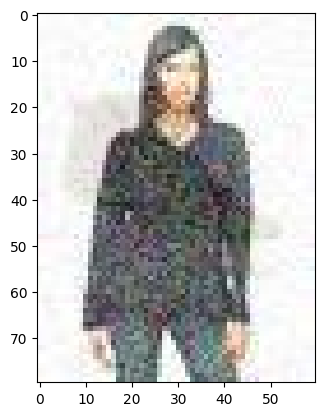

Label: 3


In [6]:
train_features, train_labels = next(iter(train_dataloader))

print(f'Feature batch shape: {train_features.size()}')
print(f'Labels batch shape: {train_labels.size()}')
print(f'Feature 0: {train_features[0]}')

img = torch.movedim(train_features[0], 0, 2).int()
label = train_labels[0]
plt.imshow(img)
plt.show()

print(f'Label: {label}')

In [7]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        ch_in = 3
        ch_1 = 16
        ch_2 = 32
        ch_3 = 64
        ch_4 = 64

        self.conv1 = nn.Conv2d(ch_in, ch_1, 3, padding='same')
        self.conv2 = nn.Conv2d(ch_1, ch_2, 3, padding='same')
        self.conv3 = nn.Conv2d(ch_2, ch_3, 3, padding='same')
        self.conv4 = nn.Conv2d(ch_3, ch_4, 3, padding='same')

        self.pool = nn.MaxPool2d(2, 2)
        self.drop = nn.Dropout(0.3)
        # self.drop = nn.Dropout(0.2)
        self.dropfc = nn.Dropout(0.5)
        # self.dropfc = nn.Dropout(0.4)

        self.bn1 = nn.BatchNorm2d(ch_1)
        self.bn2 = nn.BatchNorm2d(ch_2)
        self.bn3 = nn.BatchNorm2d(ch_3)
        self.bn4 = nn.BatchNorm2d(ch_4)

        self.fc1 = nn.Linear(ch_4*20*15, 512)
        self.fc2 = nn.Linear(512, 27)

    def forward(self, x):
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = F.relu(x1)

        x2 = self.conv2(x1)
        x2 = self.bn2(x2)
        x2 = F.relu(x2)

        x2 = self.pool(x2)
        x2 = self.drop(x2)

        x3 = self.conv3(x2)
        x3 = self.bn3(x3)
        x3 = F.relu(x3)

        x4 = self.conv4(x3)
        x4 = self.bn4(x4)
        x4 = F.relu(x4) + x3

        x4 = self.pool(x4)
        x4 = self.drop(x4)

        xf = torch.flatten(x4, 1) # flatten all dimensions except batch
        xf = F.relu(self.fc1(xf))
        xf = self.dropfc(xf)
        xf = F.log_softmax(self.fc2(xf), 1)
        return xf

In [8]:
def train_epoch(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    train_loss, correct = 0, 0

    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        pred = model(X)
        loss = loss_fn(pred, y)
        train_loss += loss.item()
        correct += (pred.argmax(1) == y).type(torch.float).sum().item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    average_train_loss = train_loss / num_batches
    accuracy = correct / size
    return accuracy, average_train_loss

def test_epoch(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    model.eval()
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    average_test_loss = test_loss / num_batches
    accuracy = correct / size
    return accuracy, average_test_loss

def train_full(train_dataloader, val_dataloader, model, loss_fn, optimizer, epochs=10, save_weights=False):
    train_accuracies, val_accuracies = [], []
    top_val_accuracy = 0.0

    for t in tqdm(range(epochs)):
        train_accuracy, train_loss = train_epoch(train_dataloader, model, loss_fn, optimizer)
        train_accuracies += [train_accuracy]

        val_accuracy, val_loss = test_epoch(val_dataloader, model, loss_fn)
        val_accuracies += [val_accuracy]

        if val_accuracy > top_val_accuracy:
            top_val_accuracy = val_accuracy
            if save_weights:
                torch.save(model, 'image_model.pth')

        print(f"Epoch {t+1}:\t Train accuracy: {100*train_accuracy:0.1f}%\t Avg train loss: {train_loss:>6f}\t Val accuracy: {100*val_accuracy:0.1f}%\t Avg val loss: {val_loss:>6f}")

    print(f"Top val accuracy: {top_val_accuracy}")
    return train_accuracies, val_accuracies

In [11]:
%%time

image_model = CNN().to(device)

save_weights = True
load_weights = False
num_epochs = 20

if load_weights:
    image_model = torch.load('image_model.pth')

loss_fn = nn.NLLLoss()
optimizer = torch.optim.Adam(image_model.parameters())

# train_accuracies, val_accuracies = train_full(train_dataloader, val_dataloader, image_model, loss_fn, optimizer, epochs=num_epochs, save_weights=save_weights)
train_accuracies, val_accuracies = train_full(total_dataloader, val_dataloader, image_model, loss_fn, optimizer, epochs=num_epochs, save_weights=save_weights)

  5%|▌         | 1/20 [00:16<05:10, 16.35s/it]

Epoch 1:	 Train accuracy: 51.4%	 Avg train loss: 2.494831	 Val accuracy: 64.5%	 Avg val loss: 1.403792


 10%|█         | 2/20 [00:32<04:49, 16.09s/it]

Epoch 2:	 Train accuracy: 58.8%	 Avg train loss: 1.636637	 Val accuracy: 65.9%	 Avg val loss: 1.318287


 15%|█▌        | 3/20 [00:49<04:43, 16.70s/it]

Epoch 3:	 Train accuracy: 60.7%	 Avg train loss: 1.578393	 Val accuracy: 68.0%	 Avg val loss: 1.248297


 20%|██        | 4/20 [01:05<04:22, 16.39s/it]

Epoch 4:	 Train accuracy: 62.2%	 Avg train loss: 1.517889	 Val accuracy: 47.5%	 Avg val loss: 1.858198


 25%|██▌       | 5/20 [01:21<04:02, 16.19s/it]

Epoch 5:	 Train accuracy: 63.7%	 Avg train loss: 1.479734	 Val accuracy: 71.8%	 Avg val loss: 1.126656


 30%|███       | 6/20 [01:37<03:46, 16.15s/it]

Epoch 6:	 Train accuracy: 65.0%	 Avg train loss: 1.429563	 Val accuracy: 72.4%	 Avg val loss: 1.111518


 35%|███▌      | 7/20 [01:53<03:30, 16.17s/it]

Epoch 7:	 Train accuracy: 65.7%	 Avg train loss: 1.399732	 Val accuracy: 73.2%	 Avg val loss: 1.073531


 40%|████      | 8/20 [02:09<03:13, 16.10s/it]

Epoch 8:	 Train accuracy: 66.8%	 Avg train loss: 1.359874	 Val accuracy: 74.0%	 Avg val loss: 1.043547


 45%|████▌     | 9/20 [02:25<02:56, 16.03s/it]

Epoch 9:	 Train accuracy: 67.3%	 Avg train loss: 1.346576	 Val accuracy: 51.5%	 Avg val loss: 1.752531


 50%|█████     | 10/20 [02:41<02:40, 16.09s/it]

Epoch 10:	 Train accuracy: 68.0%	 Avg train loss: 1.312313	 Val accuracy: 69.6%	 Avg val loss: 1.176240


 55%|█████▌    | 11/20 [02:57<02:23, 15.99s/it]

Epoch 11:	 Train accuracy: 68.6%	 Avg train loss: 1.289742	 Val accuracy: 64.7%	 Avg val loss: 1.365922


 60%|██████    | 12/20 [03:13<02:07, 15.96s/it]

Epoch 12:	 Train accuracy: 69.0%	 Avg train loss: 1.272038	 Val accuracy: 75.4%	 Avg val loss: 0.978360


 65%|██████▌   | 13/20 [03:29<01:52, 16.08s/it]

Epoch 13:	 Train accuracy: 69.6%	 Avg train loss: 1.255641	 Val accuracy: 46.2%	 Avg val loss: 1.709758


 70%|███████   | 14/20 [03:45<01:36, 16.00s/it]

Epoch 14:	 Train accuracy: 70.3%	 Avg train loss: 1.224203	 Val accuracy: 60.0%	 Avg val loss: 1.500757


 75%|███████▌  | 15/20 [04:01<01:19, 15.98s/it]

Epoch 15:	 Train accuracy: 70.9%	 Avg train loss: 1.202067	 Val accuracy: 76.5%	 Avg val loss: 0.930908


 80%|████████  | 16/20 [04:17<01:04, 16.09s/it]

Epoch 16:	 Train accuracy: 71.4%	 Avg train loss: 1.185290	 Val accuracy: 76.5%	 Avg val loss: 0.922194


 85%|████████▌ | 17/20 [04:33<00:48, 16.05s/it]

Epoch 17:	 Train accuracy: 72.1%	 Avg train loss: 1.168311	 Val accuracy: 76.7%	 Avg val loss: 0.945001


 90%|█████████ | 18/20 [04:49<00:32, 16.00s/it]

Epoch 18:	 Train accuracy: 72.7%	 Avg train loss: 1.144826	 Val accuracy: 78.8%	 Avg val loss: 0.845926


 95%|█████████▌| 19/20 [05:06<00:16, 16.14s/it]

Epoch 19:	 Train accuracy: 73.4%	 Avg train loss: 1.131212	 Val accuracy: 78.6%	 Avg val loss: 0.864581


100%|██████████| 20/20 [05:21<00:00, 16.10s/it]

Epoch 20:	 Train accuracy: 73.3%	 Avg train loss: 1.119398	 Val accuracy: 79.1%	 Avg val loss: 0.844477
Top val accuracy: 0.7910309754969949
CPU times: user 5min 2s, sys: 17.4 s, total: 5min 19s
Wall time: 5min 22s


In [12]:
if save_weights or load_weights:
    image_model = torch.load('image_model.pth')

image_model.eval()

def make_predictions(df):
    eval_dataset = ImageData(df, transform=data_transforms['val'], test=True)
    eval_dataloader = DataLoader(eval_dataset, batch_size=128, shuffle=False)

    predictions = []
    for _, X in enumerate(eval_dataloader):
        X = X.to(device)

        pred = image_model(X)
        labels = pred.argmax(1)
        for j in range(pred.shape[0]):
            predictions.append(i_to_c[labels[j].item()])

    return predictions

def eval_pred(base, pred):
    assert(base['id'].equals(pred['id']))
    print('ids match')
    diff_count = (base['category'] == pred['category']).value_counts()

    return (100.0*diff_count[True])/len(base)


In [ ]:
%%time

test_features = ['id']

df = pd.read_csv('train.csv')
train_pred = df[['id']]
train_pred['category'] = make_predictions(df)

print(f'train accuracy: {eval_pred(df, train_pred)}')

df_test = pd.read_csv('test.csv')
test_pred = df_test[['id']]
test_pred['category'] = make_predictions(df_test)
assert(df_test['id'].equals(test_pred['id']))

<timed exec>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ids match
train accuracy: 79.90474869376243


In [ ]:
train_pred.to_csv('image_train_pred.csv', index=False)
test_pred.to_csv('image_test_pred.csv', index=False)